### Import relevant packages

In [7]:
import sklearn.linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

clip = lambda x, x_min = -1, x_max = 1: np.where(np.where(x < x_min,x_min,x) > x_max, x_max, np.where(x < x_min,x_min,x)) # Clip an array to values between x_min and x_max.

### Load data files for responses

In [8]:
responses = pd.read_csv(os.path.join('..','data','responses.csv'), dtype = {'participant':str})

### Generate ground-truth labels
Ground truth labels refer to the actual, true, or correct values of the target variable (or labels) in a supervised machine learning task. In other words, these are the known outcomes or responses associated with the input data points. The purpose of ground truth labels is to provide a basis for training and evaluating machine learning models.

First I select the attributes and I give them weights (for ISO pleasantness, not eventfulness):
- Pleasant: 1
- Eventful: 0
- Chaotic: -sqrt(2)/2
- Vibrant: sqrt(2)/2
- Uneventful: 0
- Calm: sqrt(2)/2
- Annoying: -1
- Monotonous: -sqrt(2)/2

![Captura de pantalla 2024-02-18 a las 18.49.16.png](<attachment:Captura de pantalla 2024-02-18 a las 18.49.16.png>)

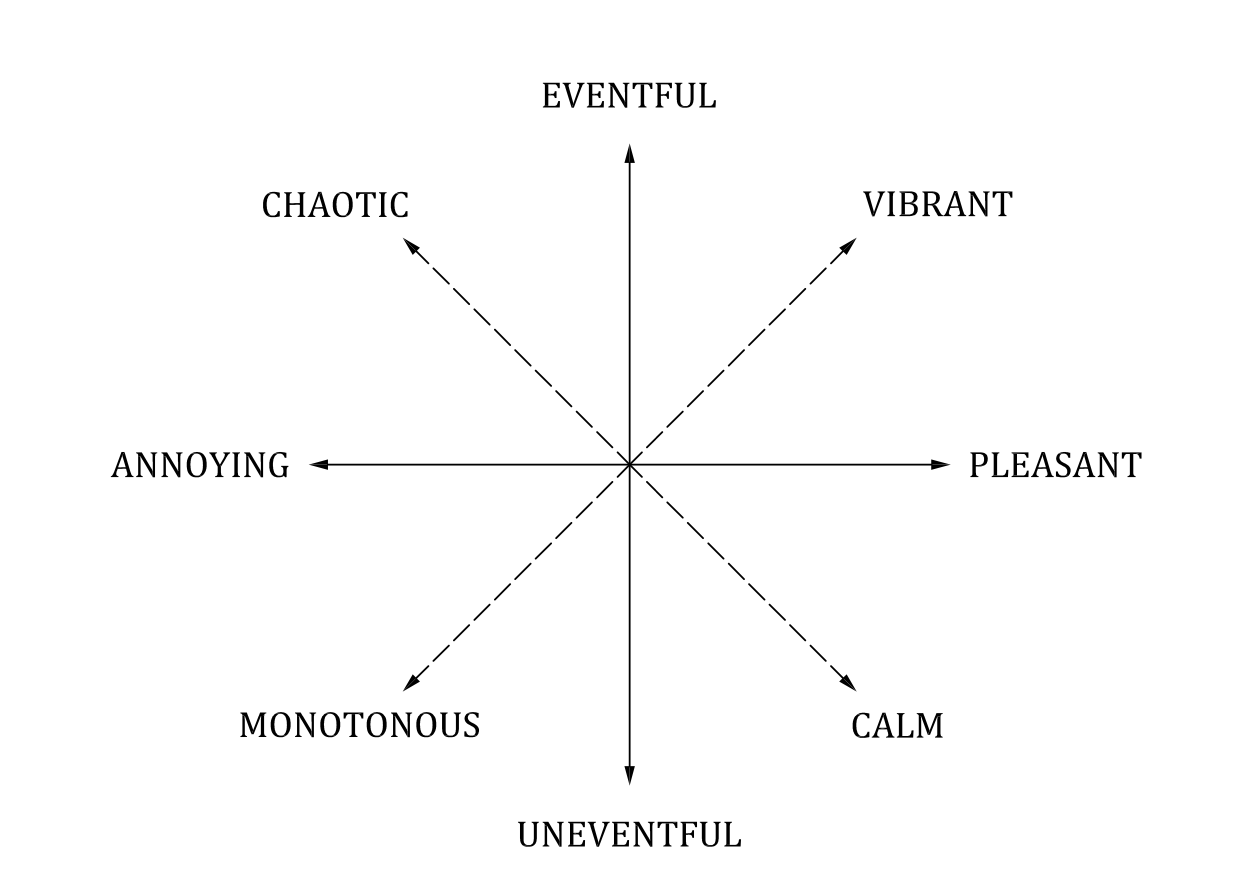

In [9]:
attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous'] # Define attributes to extract from dataframes
ISOPl_weights = [1,0,-np.sqrt(2)/2,np.sqrt(2)/2, 0, np.sqrt(2)/2,-1,-np.sqrt(2)/2] # Define weights for each attribute in attributes in computation of ISO Pleasantness

responses_copy = responses.copy() 
responses_copy['ground_truth_label'] = ((responses[attributes] * ISOPl_weights).sum(axis=1)/(4+np.sqrt(32))).values # These are normalised ISO Pleasantness values (in [-1,1])

Formula comes from ISO 12913-3

![Captura de pantalla 2024-02-18 a las 19.03.38.png](<attachment:Captura de pantalla 2024-02-18 a las 19.03.38.png>)
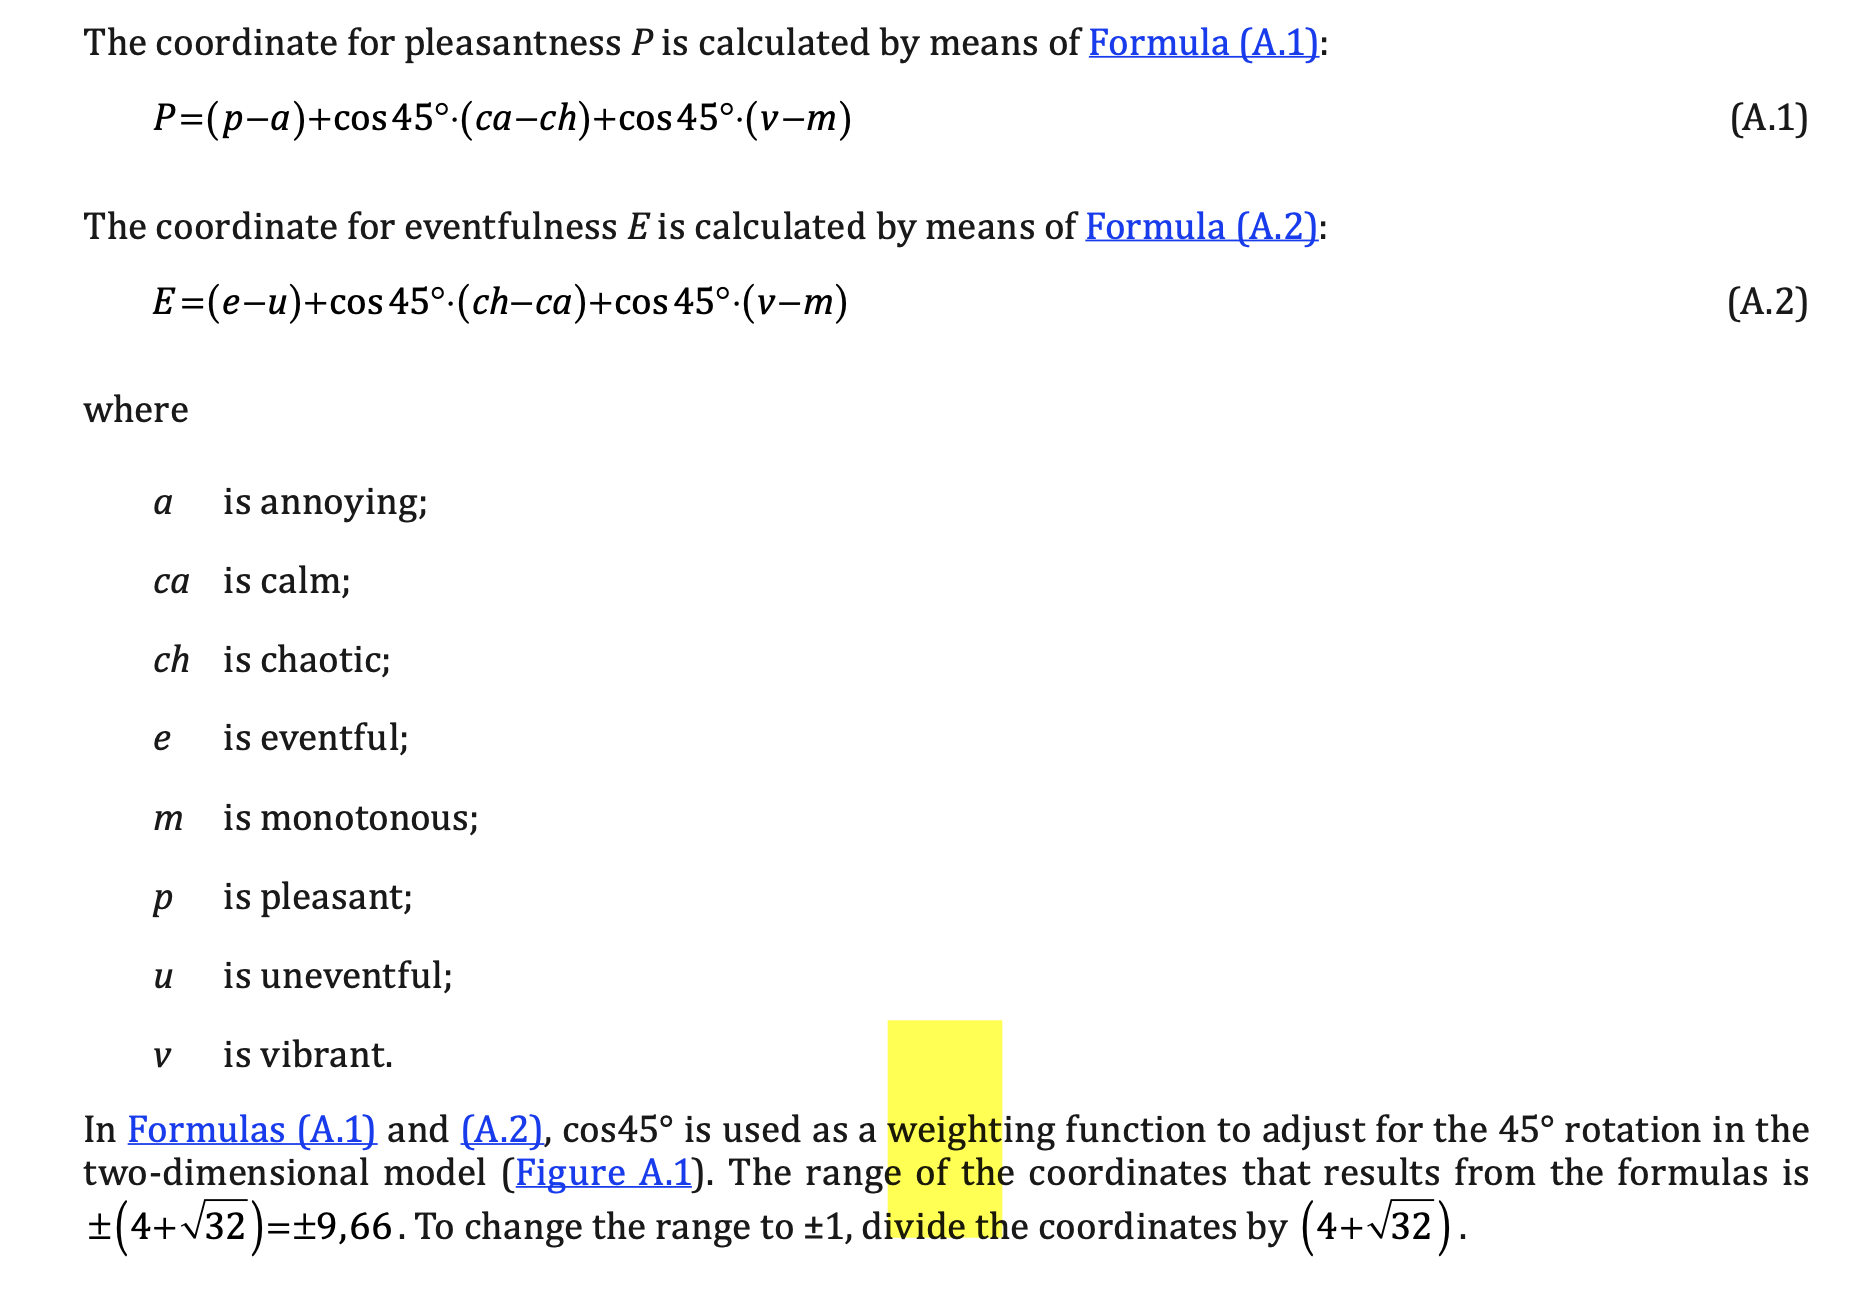

## Dummy "lavel mean" model

Now, we compute the relevant metrics for a dummy "label mean" model, which just predicts the mean of the ground-truth labels in its training set no matter the input (Regardless of the input feature, the dummy "label mean" model always predicts the calculated mean value)

In [10]:
train_mmse = 0
val_mmse = 0
test_mmse = 0
print('     |    Mean squared error    |        |       # samples      ')
print('Fold |--------+--------+--------| Label  |-------+-------+------')
print('     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test ')
print('-----+--------+--------+--------+--------+-------+-------+------')
df_trains = [] # For plotting the distributions of ISO Pleasantness labels in next block
df_vals = [] # For plotting the distributions of ISO Pleasantness labels in next block
for val_fold in [1,2,3,4,5]:
    # For the training set, use all samples that are not in the test set (fold 0) and current validation fold.
    df_train = responses_copy[(responses_copy['fold_r'] != val_fold) & (responses_copy['fold_r'] > 0)] 
    # For the test set, use all samples that are in the current validation fold.
    df_val   = responses_copy[responses_copy['fold_r'] == val_fold]
    # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth
    df_test  = responses_copy[responses_copy['fold_r'] == 0].groupby(['soundscape','masker','smr']).mean() # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth
    
    #Add ground truth labels to empty arrays for later plotting
    df_trains.append(df_train['ground_truth_label'])
    df_vals.append(df_val['ground_truth_label'])
    
    # This will be the model's prediction for all unseen data (output for any input)
    y_hat = df_train['ground_truth_label'].mean() 
    
    # Compute MSE on training set for label mean model
    train_mse = ((df_train['ground_truth_label'] - y_hat)**2).mean() 
    # Compute MSE on validation set for label mean model
    val_mse   = ((  df_val['ground_truth_label'] - y_hat)**2).mean() 
    # Compute MSE on test set for label mean model
    test_mse  = (( df_test['ground_truth_label'] - y_hat)**2).mean() 
    
    train_mmse += train_mse
    val_mmse += val_mse
    test_mmse += test_mse
    
    print(f'{val_fold:4d} | {train_mse:.4f} | {val_mse:.4f} | {test_mse:.4f} | {y_hat:.4f} | {df_train.shape[0]:5d} | {df_val.shape[0]:5d} | {df_test.shape[0]:^5d}')

print(f'Mean | {train_mmse/5:.4f} | {val_mmse/5:.4f} | {test_mmse/5:.4f}')

     |    Mean squared error    |        |       # samples      
Fold |--------+--------+--------| Label  |-------+-------+------
     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test 
-----+--------+--------+--------+--------+-------+-------+------
   1 | 0.1557 | 0.1532 | 0.1173 | 0.0208 | 20160 |  5040 |  48  
   2 | 0.1563 | 0.1507 | 0.1207 | 0.0317 | 20160 |  5040 |  48  
   3 | 0.1542 | 0.1588 | 0.1204 | 0.0307 | 20160 |  5040 |  48  
   4 | 0.1531 | 0.1631 | 0.1196 | 0.0281 | 20160 |  5040 |  48  
   5 | 0.1562 | 0.1508 | 0.1179 | 0.0225 | 20160 |  5040 |  48  
Mean | 0.1551 | 0.1553 | 0.1192


#### Repeat process for Eventfulness

In [11]:
#Attributes weights change, now we are working along the eventfullness axis
attributes = ['pleasant', 'eventful', 'chaotic', 'vibrant', 'uneventful', 'calm', 'annoying', 'monotonous'] # Define attributes to extract from dataframes
ISOEv_weights = [0,1,np.sqrt(2)/2,np.sqrt(2)/2, -1, -np.sqrt(2)/2,0,-np.sqrt(2)/2] # Define weights for each attribute in attributes in computation of ISO Pleasantness

responses_copy2 = responses.copy() 
responses_copy2['ground_truth_label'] = ((responses[attributes] * ISOEv_weights).sum(axis=1)/(4+np.sqrt(32))).values # These are normalised ISO Pleasantness values (in [-1,1])

train_mmse = 0
val_mmse = 0
test_mmse = 0
print('     |    Mean squared error    |        |       # samples      ')
print('Fold |--------+--------+--------| Label  |-------+-------+------')
print('     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test ')
print('-----+--------+--------+--------+--------+-------+-------+------')
df_trains = [] # For plotting the distributions of ISO Pleasantness labels in next block
df_vals = [] # For plotting the distributions of ISO Pleasantness labels in next block
for val_fold in [1,2,3,4,5]:
    # For the training set, use all samples that are not in the test set (fold 0) and current validation fold.
    df_train = responses_copy2[(responses_copy2['fold_r'] != val_fold) & (responses_copy2['fold_r'] > 0)] 
    # For the test set, use all samples that are in the current validation fold.
    df_val   = responses_copy2[responses_copy2['fold_r'] == val_fold]
    # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth
    df_test  = responses_copy2[responses_copy2['fold_r'] == 0].groupby(['soundscape','masker','smr']).mean() # For the test set, the same 48 stimuli were shown to all participants so we take the mean of their ratings as the ground truth
    
    #Add ground truth labels to empty arrays for later plotting
    df_trains.append(df_train['ground_truth_label'])
    df_vals.append(df_val['ground_truth_label'])
    
    # This will be the model's prediction for all unseen data (output for any input)
    y_hat = df_train['ground_truth_label'].mean() 
    
    # Compute MSE on training set for label mean model
    train_mse = ((df_train['ground_truth_label'] - y_hat)**2).mean() 
    # Compute MSE on validation set for label mean model
    val_mse   = ((  df_val['ground_truth_label'] - y_hat)**2).mean() 
    # Compute MSE on test set for label mean model
    test_mse  = (( df_test['ground_truth_label'] - y_hat)**2).mean() 
    
    train_mmse += train_mse
    val_mmse += val_mse
    test_mmse += test_mse
    
    print(f'{val_fold:4d} | {train_mse:.4f} | {val_mse:.4f} | {test_mse:.4f} | {y_hat:.4f} | {df_train.shape[0]:5d} | {df_val.shape[0]:5d} | {df_test.shape[0]:^5d}')

print(f'Mean | {train_mmse/5:.4f} | {val_mmse/5:.4f} | {test_mmse/5:.4f}')

     |    Mean squared error    |        |       # samples      
Fold |--------+--------+--------| Label  |-------+-------+------
     | Train  |   Val  |  Test  |  mean  | Train |  Val  | Test 
-----+--------+--------+--------+--------+-------+-------+------
   1 | 0.1664 | 0.1504 | 0.0966 | -0.0322 | 20160 |  5040 |  48  
   2 | 0.1620 | 0.1676 | 0.0972 | -0.0379 | 20160 |  5040 |  48  
   3 | 0.1674 | 0.1463 | 0.0971 | -0.0376 | 20160 |  5040 |  48  
   4 | 0.1621 | 0.1676 | 0.0968 | -0.0339 | 20160 |  5040 |  48  
   5 | 0.1578 | 0.1848 | 0.0979 | -0.0452 | 20160 |  5040 |  48  
Mean | 0.1631 | 0.1633 | 0.0971
